In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.reuters.load_data()

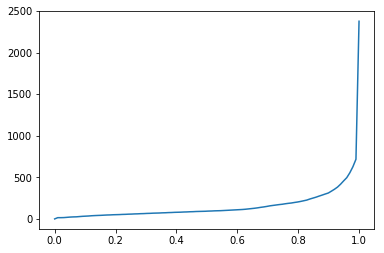

In [3]:
data_input_len_quantile_x = np.linspace(0, 1, num=100)
data_input_len_quantile_y = np.quantile(
    [len(x) for x in X_train] + [len(x) for x in X_test], data_input_len_quantile_x)
plt.plot(data_input_len_quantile_x, data_input_len_quantile_y)
plt.show()

In [4]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=64, padding='post', truncating='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=64, padding='post', truncating='post')
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8982, 64), (8982,), (2246, 64), (2246,))

In [5]:
data_input_dim = max(np.max(X_train), np.max(X_test)) + 1
data_input_dim

30979

In [6]:
data_output_dim = max(np.max(Y_train), np.max(Y_test)) + 1
data_output_dim

46

In [7]:
class AdaptiveComputationLSTMCell(keras.layers.LSTMCell):
    
    def __init__(self, *args, substeps=8, **kwargs):
        self.substeps = substeps
        super().__init__(*args, **kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        self.kernel_halt_c = self.add_weight(
            shape=(self.units, 1),
            initializer='glorot_normal', name='kernel_halt_c')
        self.kernel_halt_inputs = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='glorot_normal', name='kernel_halt_inputs')
        self.bias_halt = self.add_weight(
            shape=(1,),
            initializer='zeros', name='bias_halt')
    
    def call(self, inputs, states, **kwargs):
        state_list = []
        zero_inputs = K.zeros_like(inputs)
        for i in range(self.substeps):
            _,states = super().call(
                inputs if i == 0 else zero_inputs,
                states, **kwargs)
            state_list.append(states)
        halts = list(zip(*state_list))[1]
        halts = K.stack(halts, axis=1)
        halts = K.dot(halts, self.kernel_halt_c)
        halts = halts + K.expand_dims(
            inputs @ self.kernel_halt_inputs)
        halts = halts + self.bias_halt
        halts = K.softmax(halts, axis=1)
        state_halted = []
        for s in zip(*state_list):
            s = K.stack(s, axis=1)
            s = K.sum(s*halts, axis=1)
            state_halted.append(s)
        return state_halted[0], state_halted

In [8]:
X = X_inputs = keras.layers.Input((None,), dtype='int32')
X = keras.layers.Embedding(data_input_dim, 32, mask_zero=True)(X)
X = keras.layers.RNN(AdaptiveComputationLSTMCell(16, substeps=4))(X)
X = keras.layers.Dense(data_output_dim, activation='softmax')(X)
M = keras.Model(X_inputs, X)
M.compile('nadam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          991328    
_________________________________________________________________
rnn_1 (RNN)                  (None, 16)                3185      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                782       
Total params: 995,295
Trainable params: 995,295
Non-trainable params: 0
_________________________________________________________________


In [9]:
M.fit(X_train, Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=25, callbacks=[
    keras.callbacks.ReduceLROnPlateau(verbose=1)
])

Train on 8982 samples, validate on 2246 samples
Epoch 1/25
8982/8982 [==============================] - 25s 3ms/step - loss: 2.7941 - acc: 0.3468 - val_loss: 2.4045 - val_acc: 0.3620
Epoch 2/25
8982/8982 [==============================] - 22s 2ms/step - loss: 2.3397 - acc: 0.3517 - val_loss: 2.2877 - val_acc: 0.3620
Epoch 3/25
8982/8982 [==============================] - 22s 2ms/step - loss: 2.1278 - acc: 0.4395 - val_loss: 2.0398 - val_acc: 0.5089
Epoch 4/25
8982/8982 [==============================] - 23s 3ms/step - loss: 1.8517 - acc: 0.5140 - val_loss: 1.8142 - val_acc: 0.5561
Epoch 5/25
8982/8982 [==============================] - 22s 2ms/step - loss: 1.6662 - acc: 0.5825 - val_loss: 1.7416 - val_acc: 0.5583
Epoch 6/25
8982/8982 [==============================] - 22s 2ms/step - loss: 1.5429 - acc: 0.6173 - val_loss: 1.6476 - val_acc: 0.5913
Epoch 7/25
8982/8982 [==============================] - 22s 2ms/step - loss: 1.4315 - acc: 0.6472 - val_loss: 1.6006 - val_acc: 0.6126
Epoch 8